In [1]:
import time
import pandas as pd
import requests
import json
from tqdm import tqdm
tqdm.pandas()

from tenacity import retry, wait_random_exponential, stop_after_attempt

import re
import ast

/Users/jae/.pyenv/versions/3.7.10/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
df = pd.read_csv("Top Rated Popular Restaurants in New York City.csv")
df = df.drop_duplicates()

In [5]:
df.head()

,Name,category
0,Foxface Natural,New American
1,The Golden Swan,New American
2,Misipasta x Governors Island,Italian
3,Barbalu - Brooklyn,Italian
4,Number One Caviar Boutique,American


In [4]:
(df.groupby("category")
 .count()
 .reset_index()
 .sort_values("Name", ascending = False)
)

,category,Name
18,Italian,39
0,American,32
40,Sushi,20
20,Japanese,16
12,French,15
31,New American,10
22,Korean,9
35,Seafood,9
6,Cocktail Bar,6
25,Mediterranean,6


In [6]:
def getPlaceId(place):
    endpoint_url = "https://maps.googleapis.com/maps/api/place/autocomplete/json"
    params = {
        "input": place,
        'location': '40.7488%2C-73.9893',
        'radius': '5000',
        'key': google_maps_api_key
    }

    res = requests.get(endpoint_url, params=params)
    results =  json.loads(res.content)
    
    related_ls = ['bakery', 'bar', 'cafe', 'meal_delivery', 'meal_takeaway', 'restaurant']
    
    if len(results['predictions']) > 0:
        res_related_result = [x for x in results['predictions'] if any(k in str(x['types']) for k in related_ls)]
                  
        if len(res_related_result) > 0:
            return res_related_result[0]["place_id"]
        else:
            return "No results"
    else:
        return "No results"
    
    
def getPlacedetail(placeId):
    endpoint_url = "https://maps.googleapis.com/maps/api/place/details/json"
    params = {
        "placeid": placeId,
        'key': google_maps_api_key
    }

    res = requests.get(endpoint_url, params=params)
    results =  json.loads(res.content)
    
    params2 = {
        "placeid": placeId,
        'reviews_sort' : 'newest',
        'key': google_maps_api_key
    }

    res2 = requests.get(endpoint_url, params=params2)
    results2 =  json.loads(res2.content)
        
    results_ls = [results, results2]
    
    return results_ls



In [76]:
res_dict = {}
for place in tqdm(df["Name"]) : 
    placeId = getPlaceId(place)
    result = getPlacedetail(placeId)
    res_dict.update({place: {placeId:result} }) 

100%|█████████████████████████████████████████| 708/708 [04:27<00:00,  2.65it/s]


In [75]:
def return_dict_value(dict_, key ):
    if key in dict_.keys():
        return dict_[key]
    else :
        return 'NA'
    
def return_dict_value_tk(dict_, key, key2 ):
    if key in dict_.keys():
        if key2 in dict_[key].keys():
            return dict_[key][key2]
        else : 
            return 'NA'
    else :
        return 'NA'

In [88]:
df_ls = []
df_dict = {}
for key in res_dict.keys():
    
    if list(res_dict[key].keys())[0] == "No results":
        continue
    
    placeId  =  list(res_dict[key].keys())[0]
    result_r = res_dict[key][placeId ][0]['result']
    result_n = res_dict[key][placeId ][1]['result']
    
    
    review_ls = []
    if 'reviews' in   result_r.keys():
        review_ls = [{'review' : review['text'] , 
                     'rating' : review['rating'],
                      'author_url' : review['author_url'] } 
                     for review in result_r['reviews'] ]
    
    if 'reviews' in   result_n.keys():
        review_ls.extend([{'review' : review['text'] , 
                             'rating' : review['rating'],
                              'author_url' : review['author_url'] } 
                            for review in result_n['reviews'] ]
                        )
    
    tmp_dict = {"Name" : key, 
               "placeId ": placeId ,
               'weekday_text' : return_dict_value_tk(result_r,'current_opening_hours','weekday_text'),
                'dine_in' :  return_dict_value(result_r,'dine_in'),
                'formatted_address' :  return_dict_value(result_r,'formatted_address'),
                'geometry': {'lat': result_r['geometry']['location']['lat'],
                             'lng' : result_r['geometry']['location']['lng']},
                'photos' :  return_dict_value(result_r,'photos'),
                'rating' : return_dict_value(result_r,'rating'),
                'reservable':  return_dict_value(result_r,'reservable'),
                'serves_wine': return_dict_value(result_r,'serves_wine'),
                 'takeout': return_dict_value(result_r,'takeout'),
                'types': return_dict_value(result_r, 'types'),
                'user_ratings_total': return_dict_value(result_r,'user_ratings_total'),
                 'website':  return_dict_value(result_r,'website'),
                'reviews': review_ls
               }
    
    df_ls.append(tmp_dict)
    df_dict.update({key : tmp_dict})
    
    

In [91]:
df_w_gm = pd.DataFrame(df_ls)

In [11]:
import openai
from openai.embeddings_utils import get_embedding

openai.api_key = OPENAI_API_KEY

In [20]:
GPT_MODEL ="gpt-3.5-turbo"

@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, functions=None, model=GPT_MODEL):
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + openai.api_key,
    }
    json_data = {"model": model, "messages": messages, 'temperature':0}
    if functions is not None:
        json_data.update({"functions": functions})
    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=json_data,
        )
        return response
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e
    
    
class Conversation:
    def __init__(self):
        self.conversation_history = []

    def add_message(self, role, content):
        message = {"role": role, "content": content}
        self.conversation_history.append(message)

    def display_conversation(self, detailed=False):
        role_to_color = {
            "system": "red",
            "user": "green",
            "assistant": "blue",
            "function": "magenta",
        }
        for message in self.conversation_history:
            print(
                colored(
                    f"{message['role']}: {message['content']}\n\n",
                    role_to_color[message["role"]],
                )
            )
            


In [118]:
def process_chat_response(chat_response):
    text = chat_response.json()["choices"][0]['message']['content']
    sections = ["Cuisine Nationality", "Restaurant Type", "Specialty Dishes", "Strengths of the Restaurant", "Areas for Improvement","Overall Summary of the Restaurant"]
    data = {}
    result_dict = {}
    for i in range(len(sections)-1):
        pattern = f"{sections[i]}: (.*?)\n*{sections[i+1]}:"
        match = re.search(pattern, text, re.DOTALL)
        if match:
            data[sections[i]] = match.group(1).strip()

    # Add the last section separately as it's not followed by another section
    pattern = f"{sections[-1]}: (.*)"
    match = re.search(pattern, text, re.DOTALL)
    if match:
        data[sections[-1]] = match.group(1).strip()

    for key, value in data.items():
        result_dict.update({key: value})
        
    return result_dict

In [ ]:
df_ls = []


for row_num , reviews  in enumerate(df_w_gm["reviews"]): 
    list_of_dicts = ast.literal_eval(reviews)
    review_ls = [dict_["review"] for dict_ in list_of_dicts if len(dict_["review"])> 1]
    
    text = 'These are the reviews \n '
    for r, n in enumerate(review_ls):
        text = text + f"Review {str(r+1)}: {n} \n "
    
    conversation.add_message("user",text )
    
    conversation = Conversation()
    conversation.add_message("system", 
    """You are making the summary of the reviews of one restrauant.  
    This JSON file contains information about a specific restaurant. From the information provided, could you infer the cuisine nationality and the type of dishes the restaurant specializes in? If it's not possible to make an informed guess, kindly indicate with "N/A". Please be as accurate as possible when identifying the 'Cuisine Nationality' and 'Specialty Dishes'.
    Moreover, we'd appreciate a comprehensive summary that describes the ambiance of the restaurant, its strengths, and its weaknesses. Please avoid repeating information already mentioned in the previous sections.

    Your summary should enrich our understanding of the place. If the details provided are insufficient, feel free to augment them with plausible extrapolations while maintaining the integrity of the information.


    Please adhere to the following format for your response:

    Cuisine Nationality:
    Restaurant Type:
    Specialty Dishes:
    Strengths of the Restaurant:
    Areas for Improvement:
    Overall Summary of the Restaurant:
    """)
    
    conversation.add_message("user",text )

    chat_response = chat_completion_request(
        conversation.conversation_history )
    
    
    result_dict= process_chat_response(chat_response)
    
    tmp_dict = {"Name" : df_w_gm.iloc[row_num]["Name"],
               "Cuisine Nationality" : result_dict["Cuisine Nationality"],
               "Restaurant Type" :result_dict["Restaurant Type" ],
                "Specialty Dishes" :result_dict["Specialty Dishes"],
                "Strengths of the Restaurant" :result_dict["Strengths of the Restaurant"],
                "Areas for Improvement" :result_dict["Areas for Improvement"],
                "Overall Summary of the Restaurant" :result_dict["Overall Summary of the Restaurant"]
               }
    
    print(row_num , '/' , len(df_w_gm["reviews"]))
    
    df_ls.append(tmp_dict)

In [35]:
result_df = pd.DataFrame(df_ls) 

In [8]:
result_df = result_df.fillna("Not Available")

In [9]:
embedding_model = "text-embedding-ada-002"

In [13]:
result_df = df.merge(result_df, 'right' , on = "Name")

In [14]:
result_df["OS_embedding"] = result_df["Overall Summary of the Restaurant"].progress_apply(lambda x: get_embedding(x, engine=embedding_model))
result_df["ST_embedding"] = result_df[ "Strengths of the Restaurant"].progress_apply(lambda x: get_embedding(x, engine=embedding_model))
result_df["AI_embedding"] =result_df["Areas for Improvement"].progress_apply(lambda x: get_embedding(x, engine=embedding_model))
result_df["SD_embedding"] =result_df["Specialty Dishes"].progress_apply(lambda x: get_embedding(x, engine=embedding_model))
result_df["CG_embedding"] =result_df["category"].progress_apply(lambda x: get_embedding(x, engine=embedding_model))

100%|█████████████████████████████████████████| 212/212 [00:44<00:00,  4.75it/s]


In [15]:
result_df.head()

,Name,category,Cuisine Nationality,Restaurant Type,Specialty Dishes,Strengths of the Restaurant,Areas for Improvement,Overall Summary of the Restaurant,OS_embedding,ST_embedding,AI_embedding,SD_embedding,CG_embedding
0,Foxface Natural,New American,Mediterranean,Natural Wine Bar,"Confit mushroom with romesco, crispy goat with...",The restaurant offers high-quality ingredients...,There is no mention of any areas for improveme...,Foxface is a natural wine bar that specializes...,"[0.002897911472246051, -0.013649974949657917, ...","[0.011106226593255997, -0.015657523646950722, ...","[-0.0049005369655787945, 0.013941068202257156,...","[0.007710179779678583, -0.020429354161024094, ...","[-0.022367175668478012, 0.000900503306183964, ..."
1,The Golden Swan,New American,Not Available,Bar and Restaurant,"Carbonara, Mussels in Curry, Steak Tartare",The restaurant has a great atmosphere with a d...,Not Available,This bar and restaurant in the West Village ha...,"[0.0008331807912327349, -0.012693211436271667,...","[-0.0017851117299869657, -0.020163610577583313...","[-0.034706875681877136, -0.022115295752882957,...","[0.020966287702322006, -0.01374486368149519, 0...","[-0.022367175668478012, 0.000900503306183964, ..."
2,Barbalu - Brooklyn,Italian,Italian,Casual Dining,"Pasta, Pizza",The restaurant has a chic and comfortable ambi...,"The salads are small, and the wait time for pa...",Barbalu is a casual Italian restaurant with a ...,"[0.016737889498472214, -0.004692897200584412, ...","[0.02521410770714283, -0.008863617666065693, -...","[0.014397511258721352, -0.009359041228890419, ...","[0.03400210663676262, -0.01388942077755928, 0....","[0.006943366024643183, -0.014459662139415741, ..."
3,Number One Caviar Boutique,American,Chinese,Takeout,Not Available,The restaurant has excellent customer service ...,Some customers have reported receiving incorre...,#1 Chinese is a Chinese takeout restaurant tha...,"[0.018111230805516243, -0.006599799729883671, ...","[0.010699339210987091, -0.016497522592544556, ...","[-0.005449856631457806, -0.015512403100728989,...","[-0.034706875681877136, -0.022115295752882957,...","[0.003904648358002305, -0.001633059699088335, ..."
4,Don Angie,Italian,Italian,Fine Dining,"Lasagna, Japanese Sweet Potatoes, Chrysanthemu...",Don Angie is a highly rated Italian restaurant...,Some reviewers mentioned that the dessert was ...,Don Angie is a must-try Italian restaurant tha...,"[0.01116529293358326, -0.024137916043400764, 0...","[0.010233421809971333, -0.022172413766384125, ...","[0.0022201393730938435, -0.02435995265841484, ...","[0.019406402483582497, -0.004327734466642141, ...","[0.006943366024643183, -0.014459662139415741, ..."


# Clustering Area for Improvement

In [16]:
import numpy as np
from sklearn.cluster import KMeans

In [17]:
matrix = np.vstack(result_df.AI_embedding.values)
n_clusters = 10

kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=10)
kmeans.fit(matrix)
result_df['AI_Cluster'] = kmeans.labels_

In [18]:
result_df['AI_Cluster'].value_counts().reset_index()

,index,AI_Cluster
0,9,41
1,8,39
2,2,36
3,7,32
4,3,27
5,5,10
6,1,10
7,6,7
8,4,5
9,0,5


# Ask Chat-GPT for Cluster Summary

In [26]:
cluster_set = set(result_df["AI_Cluster"] )
cluster_st_dict = {}

for row_num , cluster in enumerate(cluster_set): 
    tmp_df = result_df[result_df["AI_Cluster"] == cluster]
    
    text = 'These are the strengths of several restaurant \n '
    for r, n in enumerate(tmp_df["Areas for Improvement"]):
        text = text + f"Restaurant {str(r+1)}: {n} \n "
    
    
    conversation = Conversation()
    conversation.add_message("system", 
    """Review the highlighted area for imporovement across multiple restaurants. Give me two keywords that are common in these problems. Make it less than 10 words. Just answer the keywords.""")
    
    conversation.add_message("user",text )

    chat_response = chat_completion_request(
        conversation.conversation_history )
    result = chat_response.json()["choices"][0]['message']['content']
        
    cluster_st_dict.update({cluster :  result})
    
    

In [27]:
for n , x in enumerate(cluster_st_dict.keys()):
    print("Cluster",x )
    print(cluster_st_dict[x])
    print(" ")

Cluster 0
Salad and consistency.
 
Cluster 1
Poor service, rushed service
 
Cluster 2
Long wait times and small portions.
 
Cluster 3
Service and Ambiance.
 
Cluster 4
No keywords provided.
 
Cluster 5
No areas for improvement.
 
Cluster 6
Portion size and price.
 
Cluster 7
High prices, lack of seasoning
 
Cluster 8
Service and Flavor
 
Cluster 9
Inconsistent service and high prices.
 


In [40]:
def adjust_AI_Cluser(cluster):
    if cluster in (0,8) : 
        return 8
    elif cluster in (4,5) : 
        return 5
    else :
        return cluster

def adjust_AI_keywords(cluster):
    keywords = cluster_st_dict[cluster]
    return keywords.replace("Keywords: ","").strip()
    

In [41]:
result_df["adjusted_AI_Cluster"] = result_df["AI_Cluster"].apply(lambda x : adjust_AI_Cluser(x)) 
result_df["Area_for_Improvement_Keywords"] = result_df["adjusted_AI_Cluster"].apply(lambda x : adjust_AI_keywords(x)) 

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

Text(0.5, 1.0, 'Visualized Area of Improvement for Popular Restaurants in New York City using t-SNE')

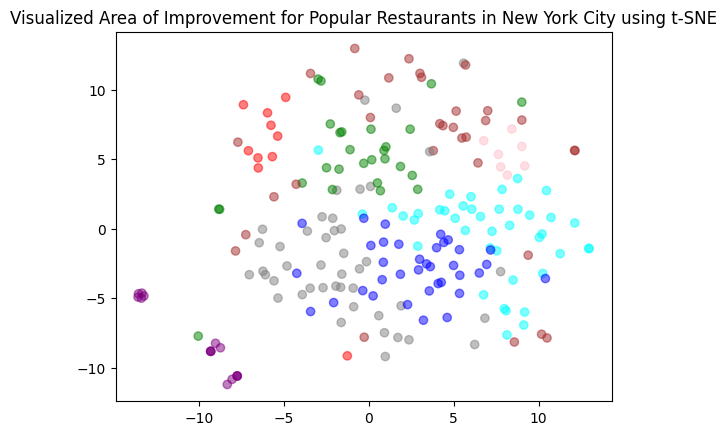

In [43]:
# matrix = ST_df.ST_embedding.apply(eval).to_list()

matrix = np.array([list(x) for x in result_df.AI_embedding])
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=30, random_state=30, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

colors = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "gray", "cyan"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = result_df.adjusted_AI_Cluster.values 

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.5)
plt.title("Visualized Area of Improvement for Popular Restaurants in New York City using t-SNE")

In [44]:
import plotly.graph_objects as go

In [45]:
tsne = TSNE(n_components=3, perplexity=30, random_state=32, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

x = [x for x, y, z in vis_dims]
y = [y for x, y, z in vis_dims]
z = [z for x, y, z in vis_dims]

color_indices = result_df.adjusted_AI_Cluster.values
colors = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "gray", "cyan"]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=6,
        color=color_indices,                # set color to an array/list of desired values
        colorscale=colors,   # choose a colorscale
        opacity=0.8
    ),
    text= result_df["Name"] + ' : ' + result_df["Area_for_Improvement_Keywords"],  # this line sets the hover text
    hoverinfo='text'  # this line ensures that only the text appears on hover
)])

fig.update_layout(
    title="Visualized Area of Improvement for Popular Restaurants in New York City using t-SNE",
    margin=dict(l=0, r=0, b=0, t=80)
)

fig.show()


In [46]:
# cluster_summary = result_df['adjusted_AI_Cluster'].value_counts().reset_index()
cluster_summary = (result_df[["Area_for_Improvement_Keywords","Name" ]]
                   .groupby(["Area_for_Improvement_Keywords" ])
                   .count()
                   .sort_values("Name", ascending = False)
                   .reset_index()
                  )

cluster_summary.columns = ["Area for Imporvment","# of Restaurants"]
cluster_summary

,Area for Imporvment,# of Restaurants
0,Service and Flavor,44
1,Inconsistent service and high prices.,41
2,Long wait times and small portions.,36
3,"High prices, lack of seasoning",32
4,Service and Ambiance.,27
5,No areas for improvement.,15
6,"Poor service, rushed service",10
7,Portion size and price.,7


# Find the most Similar  Restaurant

In [47]:
def find_closest_restaurant(Name, embedding_type,df):

    type_column_dict = {"Overall" :"Overall Summary of the Restaurant" , 
                        "Dish" : "Specialty Dishes", 
                        "Strength" : "Strengths of the Restaurant",
                        "Shortcoming" : "Areas for Improvement"}
    
    embedding_column_dict = {"Overall" :"OS_embedding" , 
                        "Dish" : "SD_embedding", 
                        "Strength" : "ST_embedding",
                        "Shortcoming" : "AI_embedding"}
    
    embeding_column = embedding_column_dict[embedding_type]
    text_column = type_column_dict[embedding_type]
    

    values = df.loc[df['Name'] == Name, embeding_column].values

    if values.size == 0:
        raise ValueError(f"No rows found with Name {Name}")

    res_embedding =  values[0]
    
    tmp_df = df[df["Name"] != Name]
    tmp_df = tmp_df[tmp_df[text_column]!= "Not Available" ]
    
    
    vec = np.array(res_embedding)
    list_vec = np.vstack(tmp_df[embeding_column].values)
    
    # Calculate the Euclidean distance between vec and each vector in list_vec
    distances = np.linalg.norm(list_vec - vec, axis=1)
    
    # Get the index of the smallest distance
    index = np.argmin(distances)
    
    # Return the closest merchant name with the category and 
    text = df["Name"].iloc[index] + "(" + df["category"].iloc[index] + ")\n" + df[text_column].iloc[index]

    return text



In [48]:
result = find_closest_restaurant('Don Angie', "Overall",result_df)
print(result)

Salinas(Spanish)
Salinas is a Spanish fine dining restaurant with a beautiful ambiance and excellent service. The restaurant specializes in a variety of dishes, including rice paella, squid ink croquets, and steak. The seafood rice, smoked salt cod on toast, bravas with caviar, beetroot with anchovies, and Basque cheesecake are also highly recommended. The restaurant has knowledgeable staff and great bartenders who make amazing cocktails. Some customers have mentioned issues with plating and wobbly tables, but overall, Salinas is a great place for a special occasion or a nice evening out.


In [49]:
result2 = find_closest_restaurant('Don Angie', "Dish",result_df)
print(result2)

Blue Haven-West Village(American)
General Tso Cauliflower, wings, and chicken tenders


In [50]:
result3 = find_closest_restaurant('Don Angie',"Strength",result_df)
print(result3)

Ploo(Mexican)
High-quality ingredients, flavorful and inventive dishes, attentive and friendly staff, welcoming and modern atmosphere


In [51]:
result4 = find_closest_restaurant('Don Angie',"Shortcoming" ,result_df)
print(result4)

Sushi Seki Chelsea(Sushi)
None mentioned in the reviews
